In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from silentsub.problem import SilentSubstitutionProblem
from silentsub.CIE import get_CIES026

In [2]:
# Functions for waveform
def get_time_vector(duration):
    t = np.arange(0, (duration*1000), 10).astype("int")
    return t


def sinusoid_modulation(f, duration, Fs=50):
    x = np.arange(duration * Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm


def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm*amplitude)).astype("int")
    return ivals

In [3]:
# Set up calibration data
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led', 'intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'
spds = spds.sort_index()
spds

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

ss = SilentSubstitutionProblem(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1,
    isolate=['S'],
    silence=['M', 'L', 'I']
    )

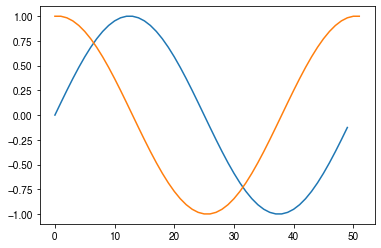

In [4]:
# Target contrast vals for modulation
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * 1.
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

S-cone contrast modulation
==========================

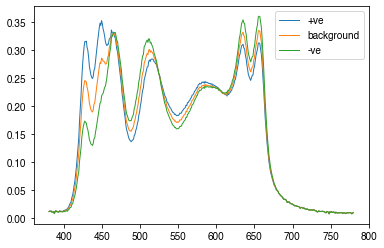

In [5]:


# Background is all channels at half power
bg_settings = np.array([.5]*10)

# Calcualte modulation spectra for S-cone modulation
contrast_mods = [ss.pseudo_inverse_contrast(bg_settings, [tc, 0, 0, 0]) for tc in target_contrasts]
spectra = [bg_settings + mod for mod in contrast_mods]

plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[0]), lw=1, label='+ve')
plt.plot(ss.predict_multiprimary_spd(bg_settings), lw=1, label='background')
plt.plot(ss.predict_multiprimary_spd(bg_settings+contrast_mods[-1]), lw=1, label='-ve')
plt.legend()


Modulation peak
---------------

	(array([ 0.00200915]), array([ 0.00635661,  0.00556619,  0.00388945]), array([ 0.14078168]))
	Background luminance: 18248.091718337455
	Modulation luminance: 18354.014503664734
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.3243896   0.30932558]


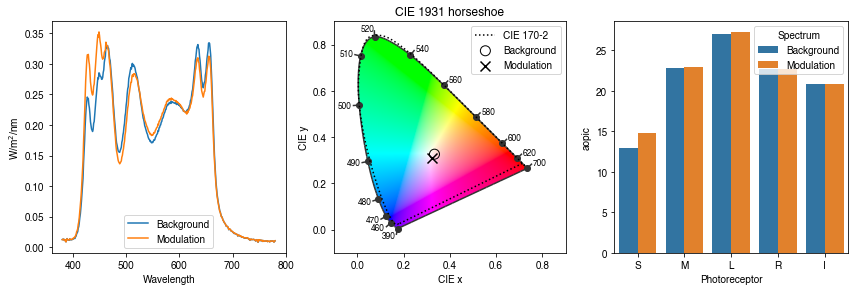

S-cone contrast: [ 0.14078168]
Splatter: [ 0.00635661  0.00556619  0.00388945]


In [6]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[0]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[0]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Modulation trough
-----------------

	(array([-0.00087788]), array([-0.00394845, -0.00205894, -0.00290752]), array([-0.1414548]))
	Background luminance: 18248.091718337455
	Modulation luminance: 18200.17864939458
	Background xy: [ 0.33326447  0.32618367]
	Modulation xy: [ 0.34389411  0.3455473 ]


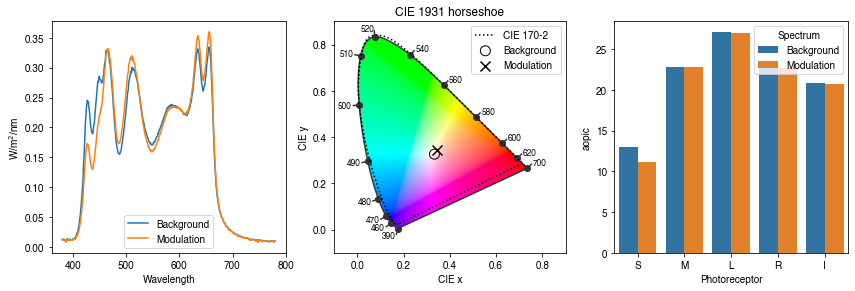

S-cone contrast: [-0.1414548]
Splatter: [-0.00394845 -0.00205894 -0.00290752]


In [7]:
ss.debug_callback_plot(np.hstack([bg_settings, spectra[-1]]))
contrasts = ss.get_photoreceptor_contrasts(np.hstack([bg_settings, spectra[-1]]))
print(f'S-cone contrast: {contrasts[2]}')
print(f'Splatter: {contrasts[1]}')

Contrast modulations
--------------------

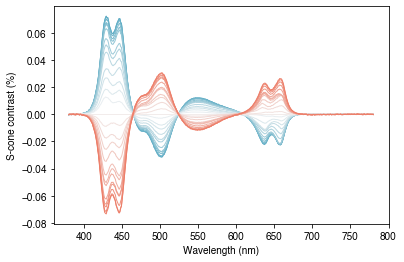

In [8]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ss.predict_multiprimary_spd(bg_settings)
for i, s in enumerate(contrast_mods):
    mod_spd = ss.predict_multiprimary_spd(bg_settings+s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

In [24]:
ss.background = bg_settings
splatter = [ss.get_photoreceptor_contrasts(list(s))[1] for s in spectra]

In [26]:
splatter = np.vstack(splatter)
splatter

array([[  6.35660549e-03,   5.56619494e-03,   3.88944903e-03],
       [  6.35660549e-03,   5.56619494e-03,   3.88944903e-03],
       [  6.34511462e-03,   5.43801057e-03,   4.11039287e-03],
       [  6.42078054e-03,   5.25230522e-03,   4.95332953e-03],
       [  5.53414607e-03,   4.37690383e-03,   5.18995659e-03],
       [  4.11275222e-03,   3.56482963e-03,   3.86049156e-03],
       [  4.48329235e-03,   4.27099132e-03,   1.15427690e-03],
       [  6.62545874e-03,   6.09012654e-03,   3.79840953e-03],
       [  3.65487594e-03,   3.60512043e-03,   1.41866956e-03],
       [  2.40936936e-03,   1.67781130e-03,   1.68524898e-03],
       [  2.61092934e-03,   1.25956305e-03,   1.63673136e-03],
       [  1.90432588e-03,   1.04281449e-03,   1.77079181e-03],
       [  2.34251377e-03,   1.90763711e-03,   3.58880079e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.70789438e-04,  -3.27286036e-04,  -5.50367244e-04],
       [  1.60852926e-03,   1.90170487e-03,   7.1565607

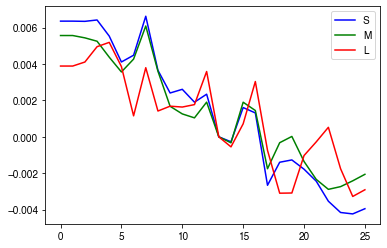

In [31]:
plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.legend()